In [1]:
%pylab inline
import tqdm
import pybinding as pb
from scipy.linalg import block_diag
from types import SimpleNamespace

Populating the interactive namespace from numpy and matplotlib


In [2]:
def surf_dos(u=-1.5, C=0.2, phi=0, L=100, W=40, num_pts=10,d0=-1,
             eran=linspace(-1,1,1000), broadening=0.01, show_tqdm=False):
    '''
    This function calculates local density of states on the edge of a coupled BHZ model.
    The considered geometry is a rectangle whose edge is at an angle phi with respect 
    to the underlying square lattice. 

    u = -1.5 # QWZ parameter
    C = 0.2  # BHZ coupling parameter
    phi=pi/2 # rotation angle
    L=100 # set aspect ratio of the rectangle
    W=40
    num_pts=10 # number of points to sample the edge
    d0=-1 # distance of sample points from edge
    eran=linspace(-1,1,1000) # energy range for the local dos calculations
    broadening=0.01 # energy broadening of LDOS calculation
    
    A SimpleNamespace object with all input parameters and also all relevant 
    calculated objects is returned.
    '''
    
    args=locals() # this is only a clever way to remember the input parameters
    # define pauli matrix
    sx = array([[0,1],
                [1,0]])
    sy = array([[0,-1j],
                [1j,0]])
    sz = array([[1,0],
                [0,-1]])

    # onsite and hopping terms defining the BHZ model with TRS^2=-1 coupling C
    U  = u*block_diag(sz,conj(sz))+C*kron(sy,sy)
    Tx = block_diag(sz+1.j*sx,conj(sz+1.j*sx))/2.
    Ty = block_diag(sz+1.j*sy,conj(sz+1.j*sy))/2.   
    
    # definition of the lattice to be a simple square lattice
    latt = pb.Lattice([1,0],[0,1])
    latt.add_one_sublattice('A',[0],U)
    latt.add_one_hopping([1,0],'A','A',Tx)
    latt.add_one_hopping([0,1],'A','A',Ty)
    
    # the sample will be a rotated rectangle cutted from a square lattice
    R=array([[cos(phi),-sin(phi)],
             [sin(phi),cos(phi)]])
    # define shape
    shape=pb.Polygon(
    (R@array([[L/2,L/2,-L/2,-L/2,L/2],
             [0.5  ,-W ,  -W,   0.5,  0.5]])).T
    )
    
    # build pybinding model
    model = pb.Model(latt,shape)
    # positions to calculate ldos
    pts = R@array([linspace(-L/6,L/6,num_pts),zeros(num_pts)+d0])
    # make shure we do not double count points
    pts = model.system.xyz[unique([model.system.find_nearest(p) for p in pts.T]),:2].T
    
    position_along_edge = array([cos(phi),sin(phi)])@(pts-mean(pts,axis=1)[:,None])
    
#    pts = array([model.system.xyz[model.system.find_nearest(p),:2]  
#             for p in results.pts.T]).T
    
    # pts = ceil(R@array([linspace(-L/6,L/6,num_pts),0.5*ones(num_pts)]))
    # pts = unique(pts,axis=1)
    # prepare kpm object
    kpm=pb.kpm(model,silent=True)

    # just an option to use or not to use tqdm
    pran=pts.T
    if show_tqdm:
        pran=tqdm.tqdm_notebook(pts.T)
    # we return a SimpleNamespace object with all input parameters and also all relevant 
    # calculated objects
    return SimpleNamespace(args = args,
                           model = model,
                           points = pts,
                           position_along_edge = position_along_edge,
                           ldos_data = [kpm.calc_ldos(energy=eran,broadening=0.01,position=p) 
                                        for p in pran ])

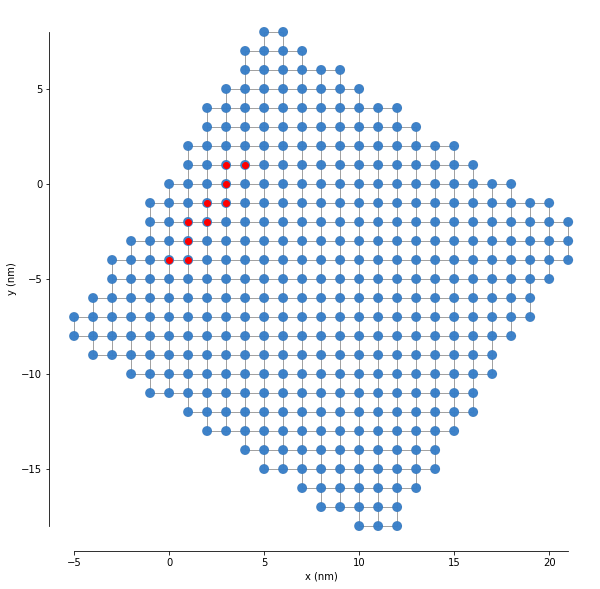

In [8]:
figure(figsize=(10,10))
results=surf_dos(u=0,C=1.0,num_pts=500,
                 L=20,W=20,d0=-2.5,
                 broadening=0.1,phi=1,
                 eran=linspace(-.25,.25,1000),
                 show_tqdm=False)
results.model.plot()
plot(*results.points,'ro')

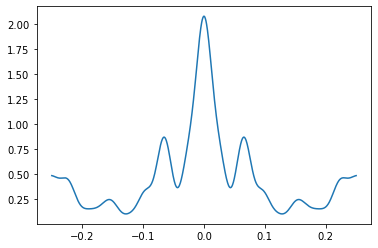

In [17]:
plot(
    results.args['eran'],
    array([l.data for l in results.ldos_data]).mean(axis=0)
    )

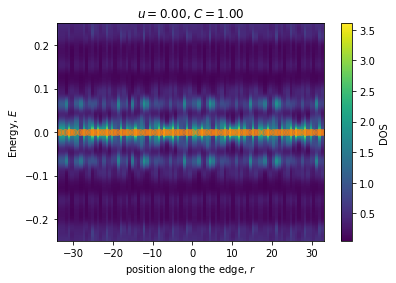

In [19]:
pcolormesh(results.position_along_edge,
           results.args['eran'],
           array([ l.data for l in results.ldos_data ]).T,)
plot(results.position_along_edge,0*results.position_along_edge,'C1o',alpha=0.5)
cax = colorbar()
cax.set_label('DOS')
ylabel(r'Energy, $E$')
xlabel(r'position along the edge, $r$')
title(f"$u=${results.args['u']:.2f}, $C=${results.args['C']:.2f}");

In [9]:
eran=linspace(-0.25,0.25,200)
phiran=linspace(0,pi/2,100)
dat=[]
for phi in tqdm.tqdm_notebook(phiran):
    results=surf_dos(u=0,C=0.1,
                     num_pts=10,
                     L=200, W=100,
                     broadening=0.1,
                     phi=phi,eran=eran,
                     show_tqdm=False)
    dat.append(array([l.data for l in results.ldos_data]).mean(axis=0))
dat=array(dat)

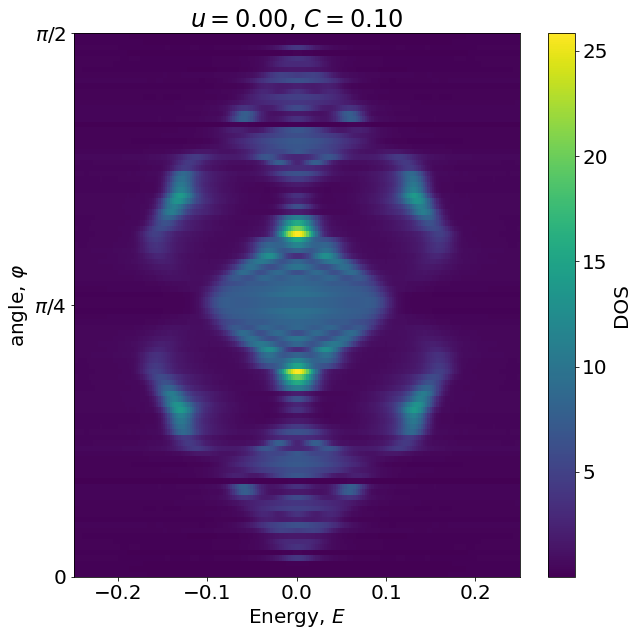

In [11]:
figure(figsize=(10,10))
plt.rcParams['font.size'] = 20
pcolormesh(eran,phiran,dat)
cax = colorbar()
#clim(0,1)
cax.set_label('DOS')
xlabel(r'Energy, $E$')
ylabel(r'angle, $\varphi$')
yticks(linspace(0,pi/2,3),[r'$0$',r'$\pi/4$',r'$\pi/2$'])
title(f"$u=${results.args['u']:.2f}, $C=${results.args['C']:.2f}");



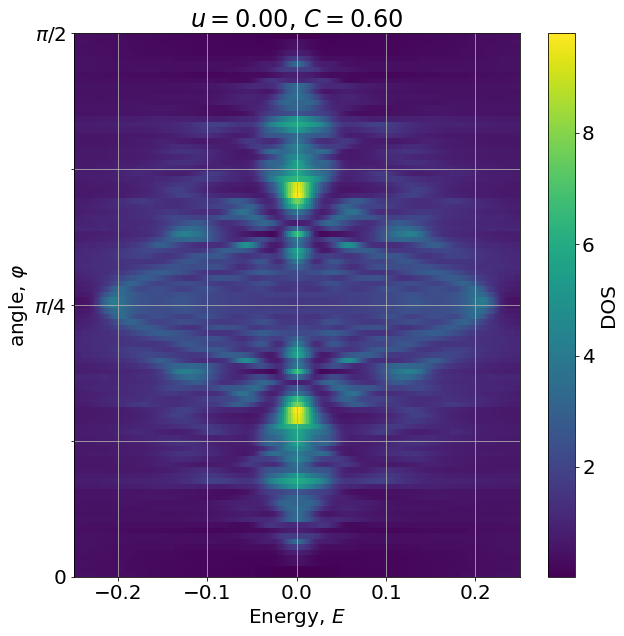

In [7]:
figure(figsize=(10,10))
plt.rcParams['font.size'] = 20
pcolormesh(eran,phiran,dat)
cax = colorbar()
#clim(0,1)
cax.set_label('DOS')
xlabel(r'Energy, $E$')
ylabel(r'angle, $\varphi$')
yticks(linspace(0,pi/2,7),[r'$0$','',r'$\pi/4$','',r'$\pi/2$'])
title(f"$u=${results.args['u']:.2f}, $C=${results.args['C']:.2f}");
grid()


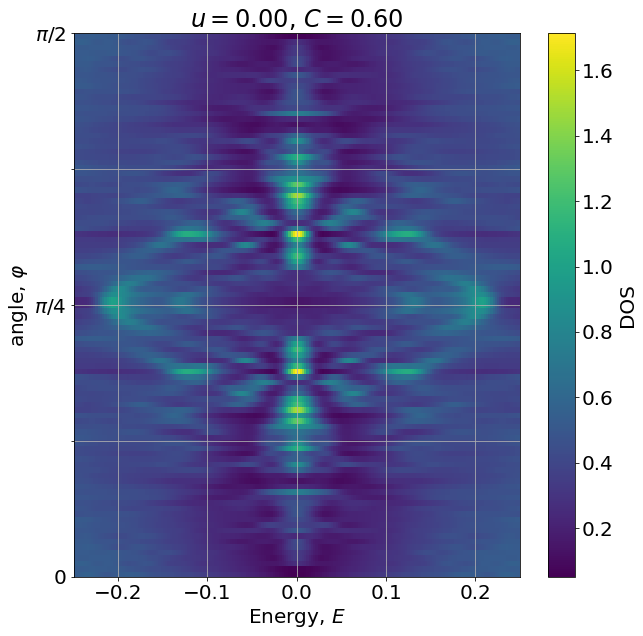

In [8]:
figure(figsize=(10,10))
plt.rcParams['font.size'] = 20
pcolormesh(eran,phiran,dat)
cax = colorbar()
#clim(0,1)
cax.set_label('DOS')
xlabel(r'Energy, $E$')
ylabel(r'angle, $\varphi$')
yticks(linspace(0,pi/2,5),[r'$0$','',r'$\pi/4$','',r'$\pi/2$'])
title(f"$u=${results.args['u']:.2f}, $C=${results.args['C']:.2f}");
grid()
